# DAGMNET + SAM
### DAGMNET v1.3:
- 3-Channel version: DWI, ADC and IS

### SAM version:
- 3-Channel version: DWI, ADC and DifDif_maps
- Original version of SAM

In [183]:
from DAGMNET_methods import *

In [184]:
def get_bounding_box(input_vol):
    bbox_vol = []
    for slice_idx in range(0,len(input_vol[0,2])):
        input_slice = input_vol[:,:,slice_idx]
        if np.sum(input_slice) > 0:
            y_indices, x_indices = np.where(input_slice > 0)
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            H, W = input_slice.shape

            # Add padding to bbox buffer to bounding box:
            pad = 2
            x_min = x_min - pad
            x_max = x_max + pad
            y_min = y_min - pad
            y_max = y_max + pad
            bbox = [x_min, y_min, x_max, y_max]
        else:
            bbox = [0,0,0,0]
        bbox_vol.append(bbox)

    return bbox_vol

In [185]:
#Run DAGMNet to create Bboxes:
prompts_from_DAGMNet = []
for i in range(0, len(df_test)):
    print('Subject:',i+1, 'of', len(df_test))
    
    # Load data
    DWI_path, ADC_path, b0_path, label_path = data[i]

    # Preprocess input:
    Dwi_ss_MNI_BSN_img, ADC_ss_MNI_BSN_img, Prob_IS, affine_map, mask_raw_img, mask_raw_MNI_img = preprocess_pipeline(ADC_path, DWI_path, b0_path, N_channel)

    # Get lesion prediction:
    stroke_pred_img = get_stroke_seg_MNI(Lesion_model, Dwi_ss_MNI_BSN_img, ADC_ss_MNI_BSN_img, Prob_IS, N_channel=N_channel)
    
    # Transform map lesion back to raw space
    model_segmentation = postprocess(stroke_pred_img, affine_map, mask_raw_img, mask_raw_MNI_img)

    # Get the bounding_box to prompt SAM:
    bbox = get_bounding_box(np.asarray(model_segmentation))
    prompts_from_DAGMNet.append(bbox)

Subject: 1 of 8
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Subject: 2 of 8
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Subject: 3 of 8
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Subject: 4 of 8
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Subject: 5 of 8
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter: 1]
Optimizing level 0 [max iter:

# Setup of SAM

In [189]:
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SamProcessor
from transformers import SamModel
from transformers import SamModel, SamConfig, SamProcessor
from datasets import Dataset as _Dataset
from tqdm import tqdm
from statistics import mean
from segment_anything import sam_model_registry
from functools import partial
from segment_anything.modeling import (ImageEncoderViT, MaskDecoder, PromptEncoder, Sam, TwoWayTransformer)
from dipy.align.imaffine import AffineRegistration
from dipy.align.transforms import AffineTransform3D

affreg = AffineRegistration(level_iters=[0])
current_directory = os.environ['HOME']

def Create_DWI_symDif_map(DWI_vol):
    # Mirror the image horizontally
    DWI_vol_mir = np.flipud(DWI_vol)

    # Register DWI_vol to mirrored DWI
    affine3d = affreg.optimize(DWI_vol, DWI_vol_mir, AffineTransform3D(), params0=None) 

    # Transform the mirrored DWI to match the original DWI_vol
    DWI_vol_trans = affine3d.transform(DWI_vol_mir)

    # Left/Right difference for DWI_vol:
    DWI_symDif_vol = DWI_vol-DWI_vol_trans

    return DWI_symDif_vol

def Create3ChannelVolumes(DWI_vol, ADC_vol, b0_vol, symDif_vol):
    DWI_slice = DWI_vol
    DWI_slice = ((DWI_slice - np.min(DWI_slice)) / (np.max(DWI_slice) - np.min(DWI_slice))).astype(float)

    # Compute the symmetric difference of left and right hemisphere from DWI:
    Sym_dif_slice = symDif_vol
    Sym_dif_slice = ((Sym_dif_slice - np.min(Sym_dif_slice)) / (np.max(Sym_dif_slice) - np.min(Sym_dif_slice))).astype(float)
    Sym_dif_slice = np.where(((Sym_dif_slice*-1+1) < DWI_slice), DWI_slice, DWI_slice*0.5)

    # Compute the difference between the modalities ADC and b0:
    b0_th = np.where(DWI_slice > (np.mean(DWI_slice)), b0_vol, 0)
    ADC_th = np.where(DWI_slice > (np.mean(DWI_slice)), ADC_vol, 0)
    modalityDif_slice = np.where(b0_th > ADC_th , DWI_slice, DWI_slice * 0.5)
    
    # Compute a dif_dif slice based on the difference between the to dif_slices:
    dif_dif_map = Sym_dif_slice * modalityDif_slice

    # Stack slices into 3-channel slice:
    DWI_vol = np.expand_dims(DWI_vol, axis=0)
    ADC_vol = np.expand_dims(ADC_vol, axis=0)
    C3_vol = np.concatenate((DWI_vol, ADC_vol), axis=0)
    dif_dif_vol = np.asarray(dif_dif_map)
    dif_dif_vol = ((dif_dif_vol - dif_dif_vol.min()) / (dif_dif_vol.max() - dif_dif_vol.min()) * 255).astype(np.uint8)
    dif_dif_vol = np.expand_dims(dif_dif_vol, axis=0)
    C3_vol = np.concatenate((C3_vol, dif_dif_vol), axis=0)

    return C3_vol

def getVolume(DWI_path, ADC_path, b0_path, label_path, bboxes):
    DWI_vol = nib.load(DWI_path).get_fdata()
    DWI_vol = ((DWI_vol - DWI_vol.min()) / (DWI_vol.max() - DWI_vol.min()) * 255).astype(np.uint8)
    
    symDif_vol = Create_DWI_symDif_map(DWI_vol)

    DWI_vol = DWI_vol.transpose(2, 0, 1)
    symDif_vol = symDif_vol.transpose(2, 0, 1)
  
    ADC_vol = nib.load(ADC_path).get_fdata()
    ADC_vol = ((ADC_vol - ADC_vol.min()) / (ADC_vol.max() - ADC_vol.min()) * 255).astype(np.uint8)
    ADC_vol = ADC_vol.transpose(2, 0, 1)

    b0_vol = nib.load(b0_path).get_fdata()
    b0_vol = ((b0_vol - b0_vol.min()) / (b0_vol.max() - b0_vol.min()) * 255).astype(np.uint8)
    b0_vol = b0_vol.transpose(2, 0, 1)
    
    label_vol = nib.load(label_path).get_fdata()
    masks = label_vol.transpose(2, 0, 1)

    #Create a list to store the indices of non-empty prompts
    valid_indices = [i for i, bbox in enumerate(bboxes) if max(bbox) != 0]
            
    # Filter the image and mask arrays to keep only the non-empty pairs
    DWI_vol = DWI_vol[valid_indices]
    ADC_vol = ADC_vol[valid_indices]
    b0_vol = b0_vol[valid_indices]
    symDif_vol = symDif_vol[valid_indices]
    filtered_masks = masks[valid_indices]

    # Convert the NumPy arrays to Pillow images and store them in a dictionary
    dataset_dict = {"DWI_vol": [Image.fromarray(img) for img in DWI_vol],
                    "ADC_vol": [Image.fromarray(img) for img in ADC_vol],
                    "b0_vol": [Image.fromarray(img) for img in b0_vol],
                    "symDif_vol": [Image.fromarray(img) for img in symDif_vol],
                    "label": [Image.fromarray(mask) for mask in filtered_masks],
                    "valid_indices": valid_indices,
    }

    # Create the dataset using the datasets.Dataset class
    return _Dataset.from_dict(dataset_dict)

def plotFunc(DWI_slice, modelout, Label_slice):
    fig, axes = plt.subplots(1, 3, figsize=(7, 7))  # Adjust figsize as needed
    axes[0].imshow(DWI_slice, cmap='gray')  # Assuming grayscale images
    axes[0].set_title('DWI slice')
    axes[0].axes.axis('off')
    axes[1].imshow(modelout, cmap='gray')  # Assuming grayscale images
    axes[1].set_title('SAM output')
    axes[1].axes.axis('off')
    axes[2].imshow(Label_slice, cmap='gray')  # Assuming grayscale images
    axes[2].set_title('Label slice')
    axes[2].axes.axis('off')
    plt.show()

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor, type, prompt):
    self.dataset = dataset
    self.processor = processor
    self.type = type
    self.prompt = prompt

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    DWI_vol = item["DWI_vol"]
    ADC_vol = item["ADC_vol"]
    b0_vol = item["b0_vol"]
    symDif_vol = item["symDif_vol"]
    ground_truth_mask = np.array(item["label"])
    valid_indices = np.array(item["valid_indices"])

    # get bounding box prompt
    prompt = self.prompt

    DWI_vol = np.array(DWI_vol)
    ADC_vol = np.array(ADC_vol)
    b0_vol = np.array(b0_vol)
    image = Create3ChannelVolumes(DWI_vol, ADC_vol, b0_vol, symDif_vol)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask
    inputs["valid_indices"] = valid_indices

    return inputs

# Load model and processor:
model = SamModel.from_pretrained("facebook/sam-vit-base") # Load the model
processor = SamProcessor.from_pretrained("facebook/sam-vit-base") # Initialize the processor

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
print('Device:',device, ':',torch.cuda.device_count())

Device: cpu : 0


Volume: 1 of 8
Optimizing level 0 [max iter: 0]


  0%|          | 0/10 [00:00<?, ?it/s]/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


Dice for slice: 0.0


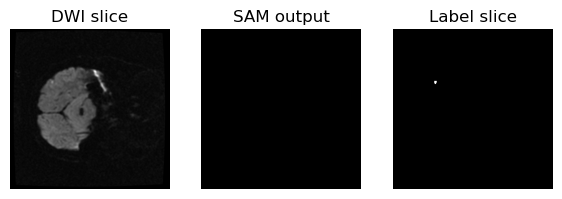

Dice for slice: 0


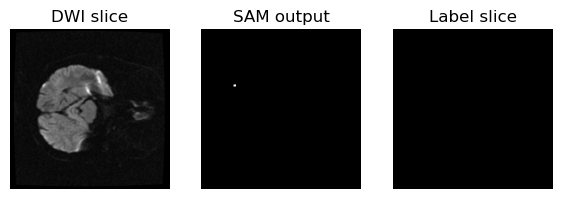

Dice for slice: 0


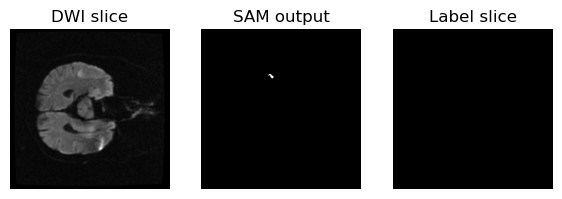

Dice for slice: 0.0


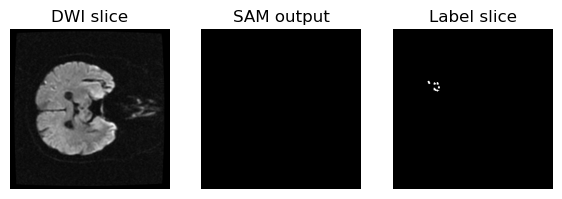

Dice for slice: 0.318


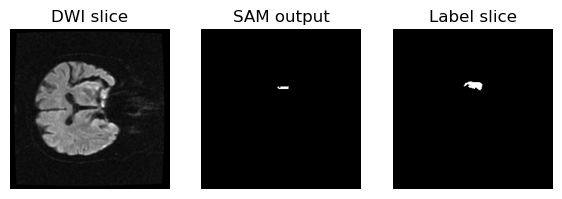

Dice for slice: 0.698


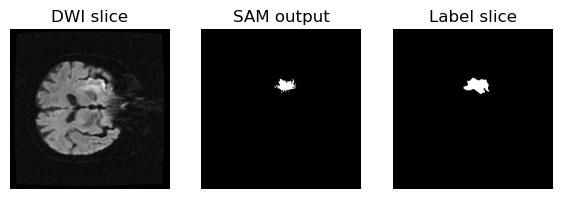

Dice for slice: 0.694


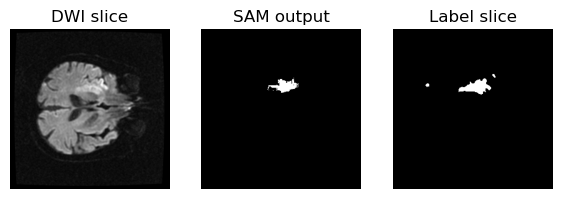

Dice for slice: 0.592


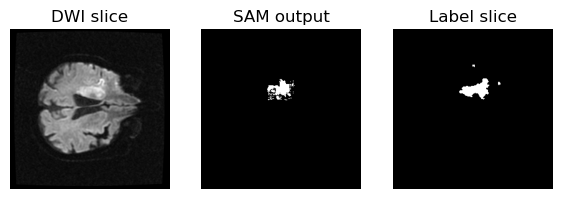

Dice for slice: 0.21


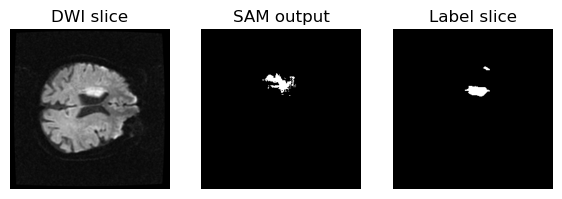

Dice for slice: 0.164


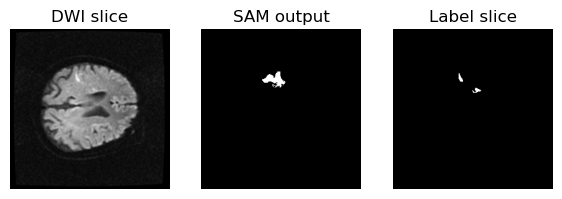

Dice for slice: 0.049


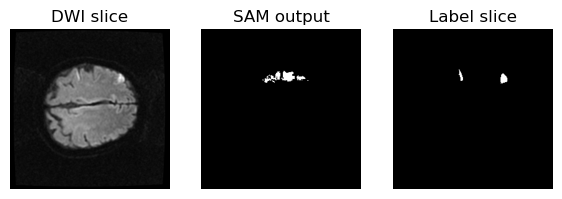

Dice for slice: 0.831


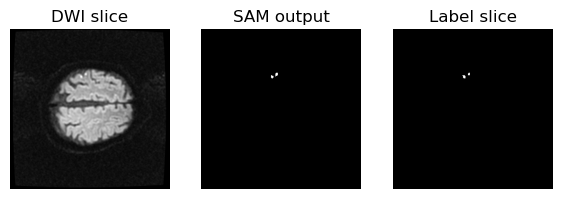

Mean slice dice for subject: 0.296
Volume dice for subject: 0.45
__________________________________
Volume: 2 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 1/1 [00:09<00:00,  9.24s/it]

Dice for slice: 0.897


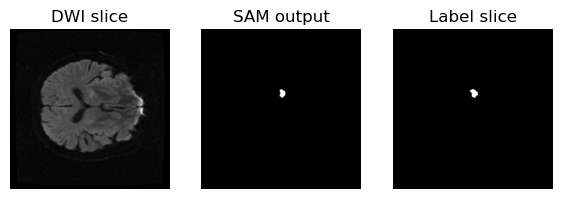

Mean slice dice for subject: 0.897
Volume dice for subject: 0.897
__________________________________
Volume: 3 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


Dice for slice: 0.301


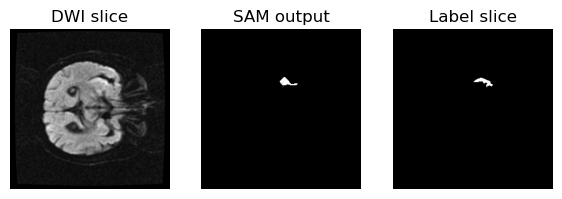

Dice for slice: 0.002


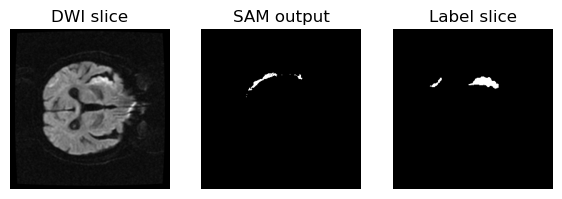

Dice for slice: 0.069


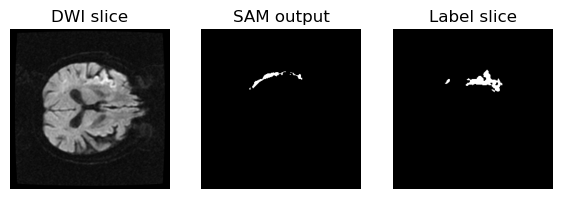

Dice for slice: 0.233


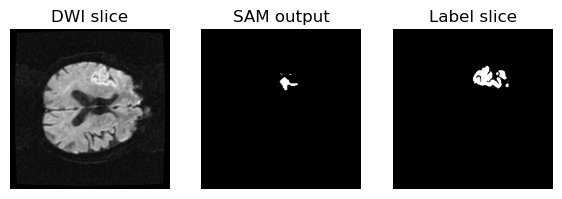

Dice for slice: 0.142


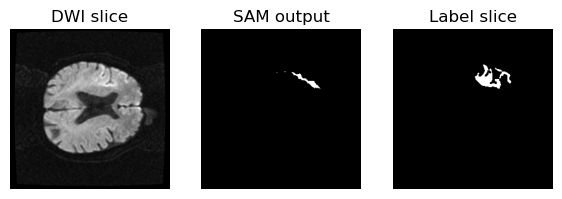

Dice for slice: 0.23


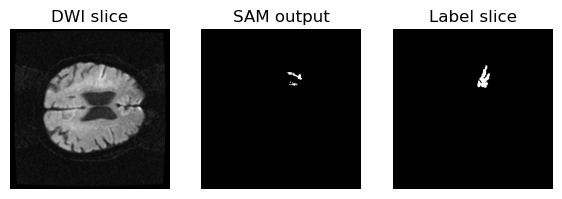

Dice for slice: 0.242


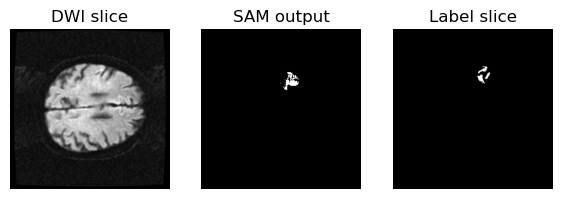

Dice for slice: 0.654


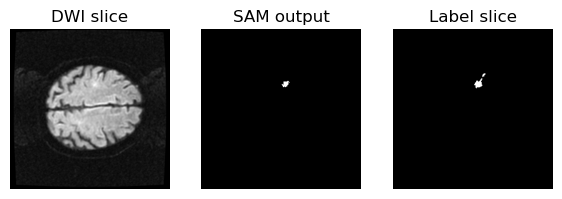

Dice for slice: 0.0


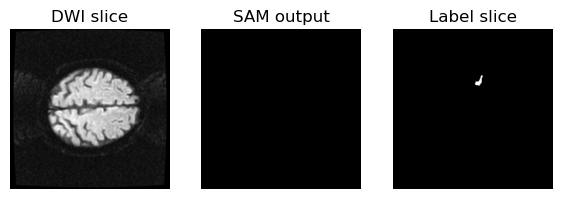

Dice for slice: 0.467


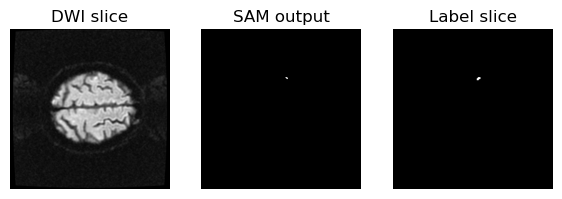

Dice for slice: 0


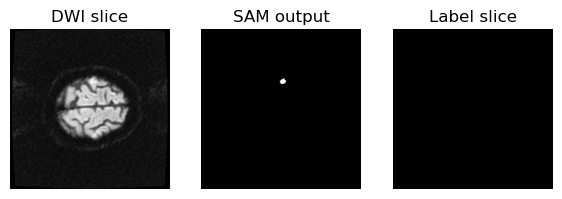

Mean slice dice for subject: 0.213
Volume dice for subject: 0.169
__________________________________
Volume: 4 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 14/14 [02:09<00:00,  9.28s/it]


Dice for slice: 0


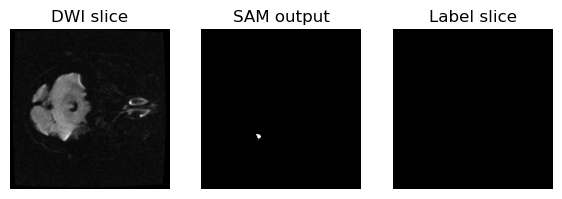

Dice for slice: 0.225


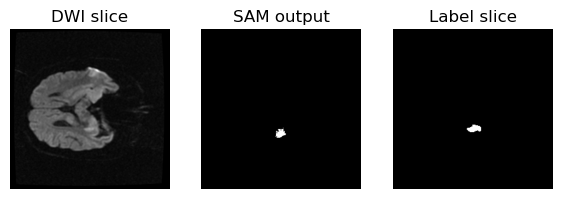

Dice for slice: 0.336


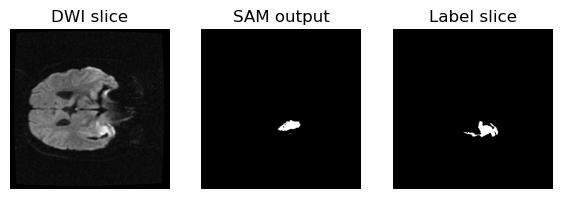

Dice for slice: 0.389


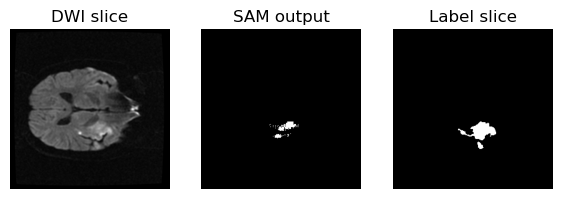

Dice for slice: 0.38


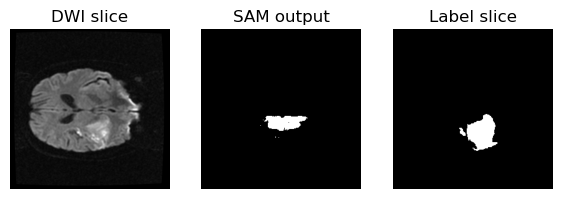

Dice for slice: 0.491


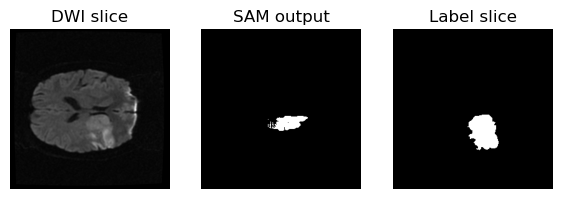

Dice for slice: 0.494


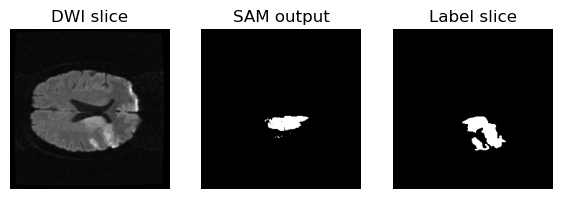

Dice for slice: 0.131


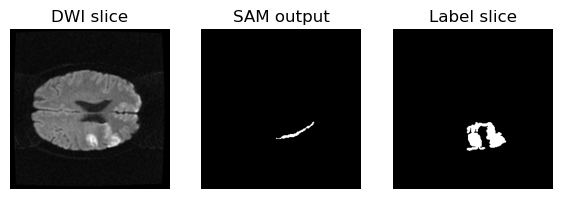

Dice for slice: 0.093


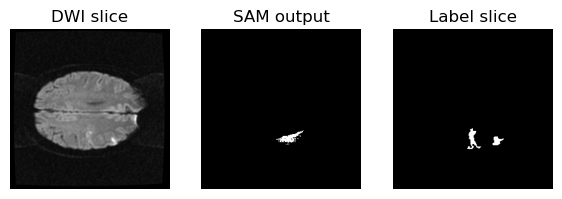

Dice for slice: 0.397


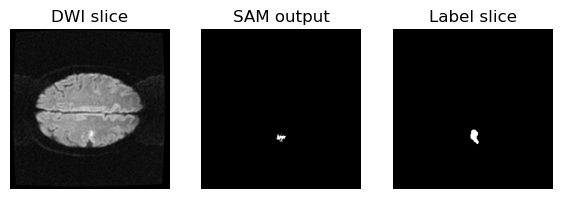

Dice for slice: 0.521


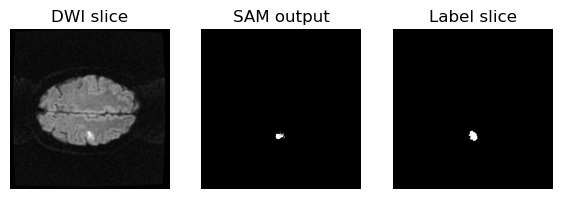

Dice for slice: 0


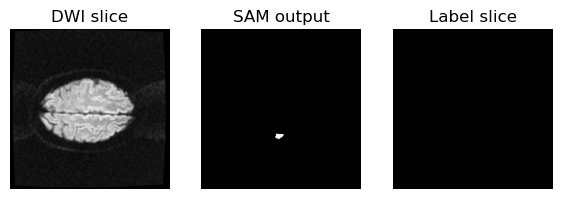

Dice for slice: 0


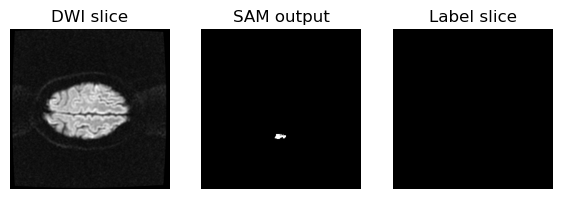

Dice for slice: 0


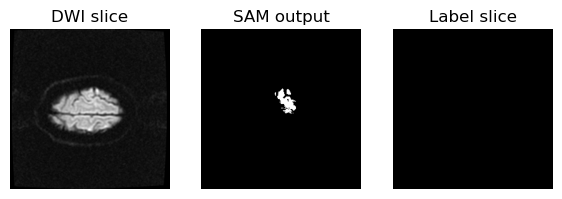

Mean slice dice for subject: 0.247
Volume dice for subject: 0.357
__________________________________
Volume: 5 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 4/4 [00:37<00:00,  9.39s/it]


Dice for slice: 0.442


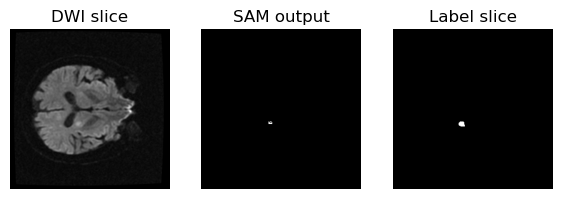

Dice for slice: 0.846


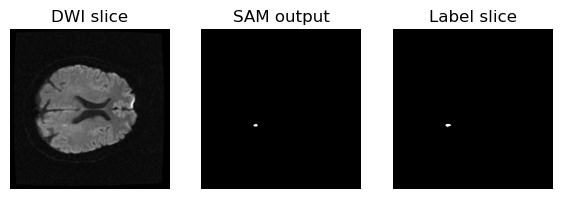

Dice for slice: 0.732


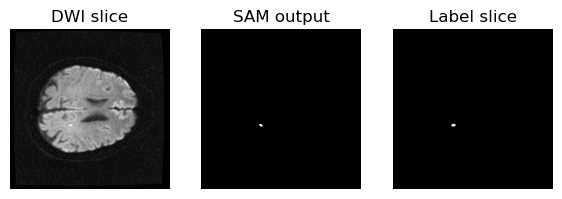

Dice for slice: 0.898


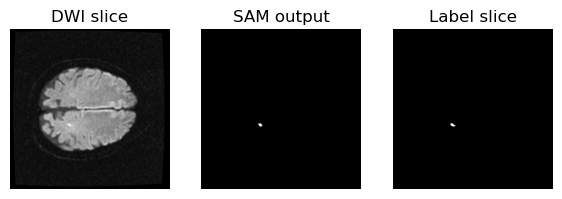

Mean slice dice for subject: 0.729
Volume dice for subject: 0.684
__________________________________
Volume: 6 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 9/9 [01:23<00:00,  9.32s/it]


Dice for slice: 0


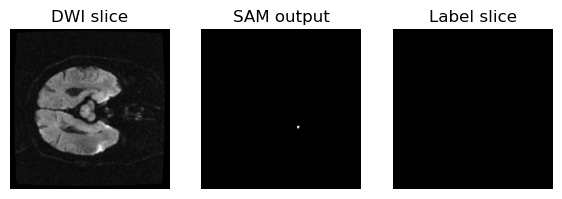

Dice for slice: 0.528


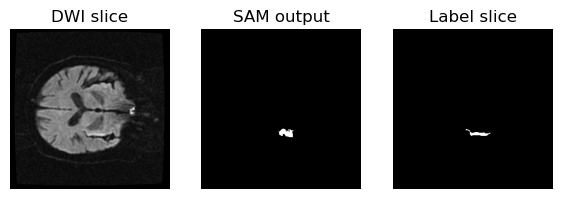

Dice for slice: 0.176


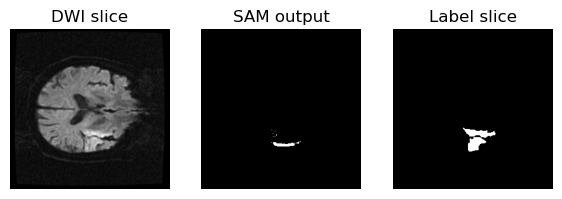

Dice for slice: 0.526


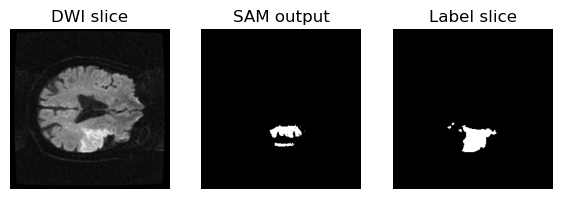

Dice for slice: 0.321


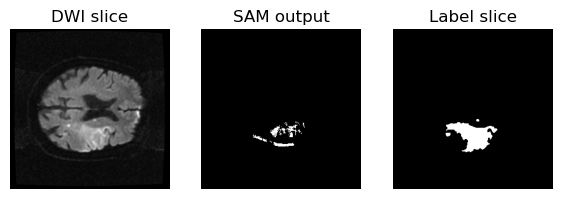

Dice for slice: 0.109


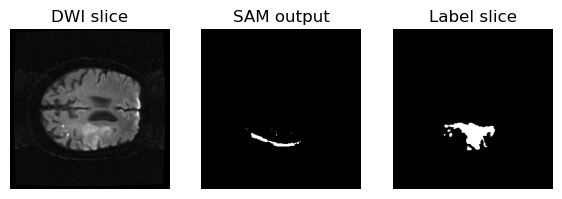

Dice for slice: 0.416


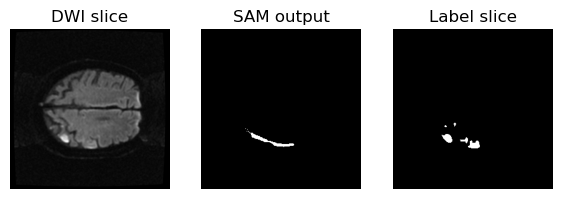

Dice for slice: 0.021


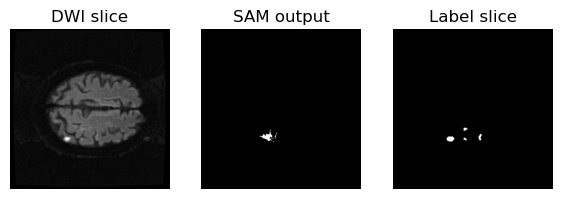

Dice for slice: 0


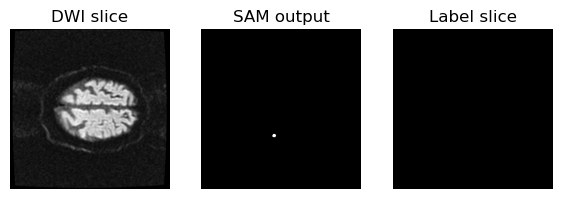

Mean slice dice for subject: 0.233
Volume dice for subject: 0.317
__________________________________
Volume: 7 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 8/8 [01:11<00:00,  8.93s/it]


Dice for slice: 0.561


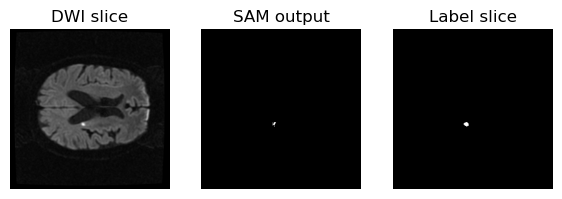

Dice for slice: 0.741


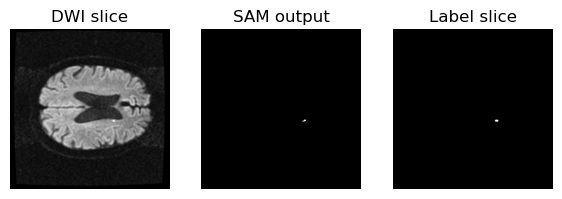

Dice for slice: 0.0


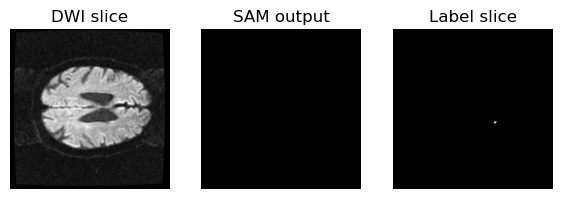

Dice for slice: 0.0


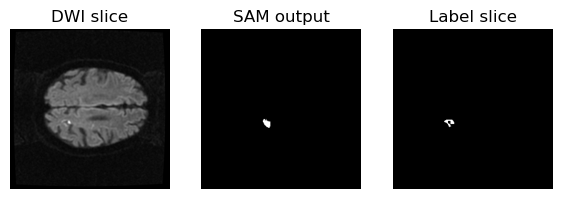

Dice for slice: 0.0


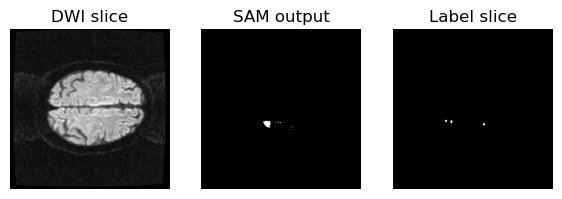

Dice for slice: 0.31


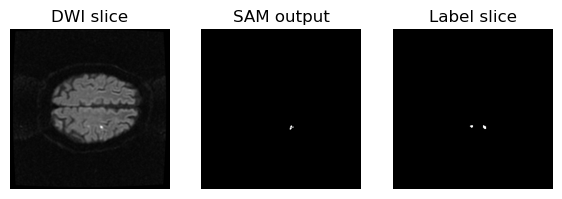

Dice for slice: 0


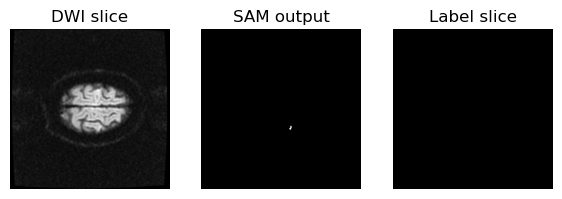

Mean slice dice for subject: 0.23
Volume dice for subject: 0.143
__________________________________
Volume: 8 of 8
Optimizing level 0 [max iter: 0]


100%|██████████| 9/9 [01:21<00:00,  9.11s/it]


Dice for slice: 0.281


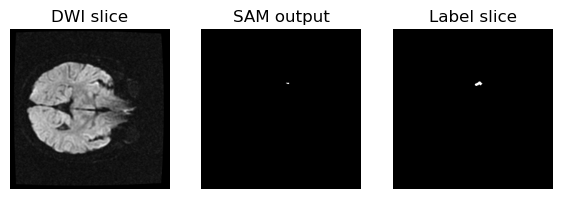

Dice for slice: 0.584


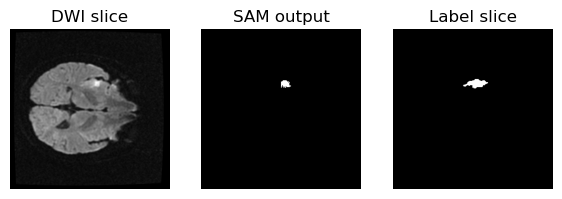

Dice for slice: 0.55


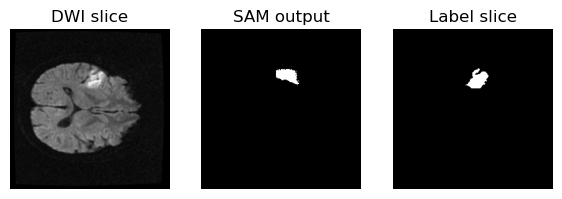

Dice for slice: 0.56


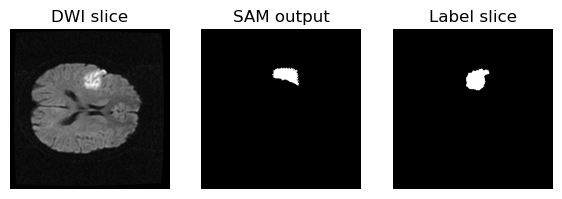

Dice for slice: 0.445


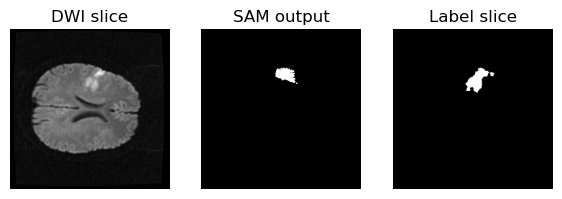

Dice for slice: 0.133


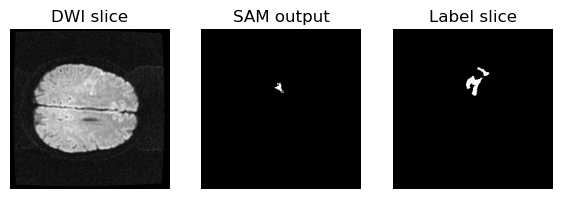

Dice for slice: 0.0


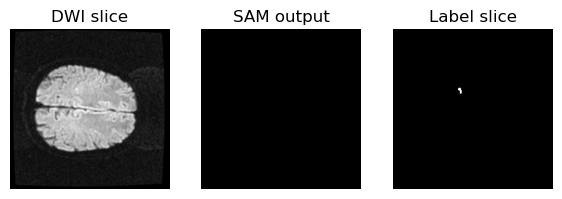

Dice for slice: 0.635


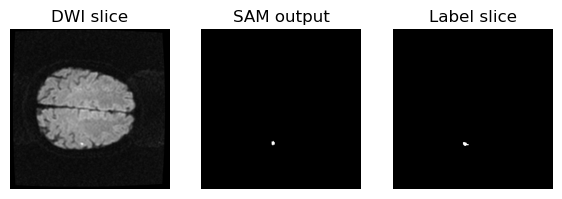

Dice for slice: 0.0


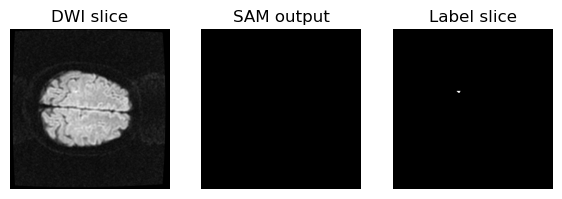

Dice for slice: 0


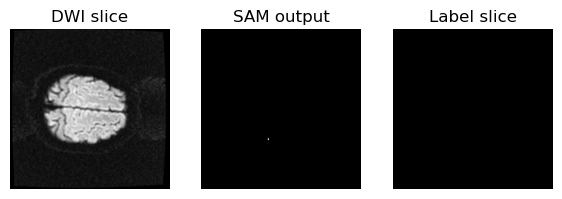

Dice for slice: 0.769


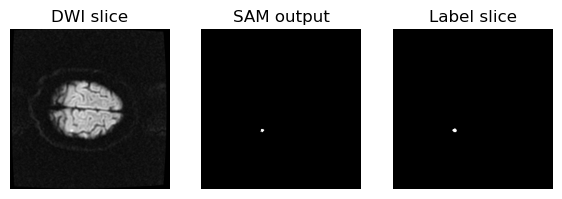

Mean slice dice for subject: 0.36
Volume dice for subject: 0.482
__________________________________
____________________________________________________________________
Mean slice dice for each subject: [0.29639509614361753, 0.896551724137931, 0.21271465168970113, 0.24690671904939632, 0.7294202030041913, 0.23303489486947537, 0.23035558244269677, 0.3596606513535495]
Volume dice for each subject: [0.4498784933171324, 0.896551724137931, 0.16853932584269662, 0.3567919267029611, 0.6842105263157895, 0.31691224983505606, 0.14285714285714285, 0.4824658545588778]

Mean slice dice for all subjects: 0.4006299403363199
Mean volume dice for all subjects: 0.4372759054459484


In [208]:
batchSize = 1
type = 'test'
Avg_Dice_subjects = [] #Slice based
Dice_for_subjects = [] #Slice based
Dice_vol_subjects = [] #Volume based
for i in range(0,len(data)):
      print(f'Volume: {i+1} of {len(data)}')
      Dice_slices = []

      # Get the bounding_box to prompt SAM:
      prompt = prompts_from_DAGMNet[i]

      # Get paths to scans and masks for each subject in the datasplit
      DWI_path, ADC_path, b0_path, label_path = data[i]

      # Load data:
      dataset = getVolume(DWI_path, ADC_path, b0_path, label_path, prompt)

      # Load dataset for SAM:
      val_dataset = SAMDataset(dataset = dataset, processor = processor, type = type, prompt = prompt)
      val_dataloader = DataLoader(val_dataset, batch_size = batchSize, shuffle = False, drop_last = False)

      for batch in tqdm(val_dataloader):
            with torch.cuda.amp.autocast():
                  outputs = model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
                  predicted_masks = outputs.pred_masks.squeeze(1)
                  output_volume = np.asarray(torch.squeeze(predicted_masks[0,:,:,:]).cpu().detach()).transpose(1, 2, 0)
            torch.cuda.empty_cache()

      # Dice for volume:
      output_volume = output_volume > 0.5
      Label_vol = nib.load(label_path).get_fdata()
      dice_vol = Find_DICE_vol(output_volume, Label_vol)
      Dice_vol_subjects.append(dice_vol)

      # Loop though each slice:
      DWI_vol = nib.load(DWI_path).get_fdata()
      for i in range (0, len(DWI_vol[0,0,:])):
            DWI_slice = DWI_vol[:,:,i]
            Label_slice = Label_vol[:,:,i]
            model_output = (output_volume[:,:,i])

            if np.sum(Label_slice) > 0 or np.sum(model_output) > 0: # "Empty" slices are not included
                        # Dice:
                        dice_slice = Find_DICE_slice(model_output, Label_slice)
                        Dice_slices.append(dice_slice)
                        print('Dice for slice:', round(dice_slice,3))

                        # Plot:
                        plotFunc(DWI_slice, model_output, Label_slice)
        
      Dice_for_subjects.append(Dice_slices)
      Avg_Dice_subjects.append(mean(Dice_slices))
      print('Mean slice dice for subject:', round(mean(Dice_slices),3))
      print('Volume dice for subject:', round(dice_vol,3))
      print('__________________________________')
print('____________________________________________________________________')
print('Mean slice dice for each subject:', Avg_Dice_subjects)
print('Volume dice for each subject:', Dice_vol_subjects)
print('')
print('Mean slice dice for all subjects:', mean(Avg_Dice_subjects))
print('Mean volume dice for all subjects:', mean(Dice_vol_subjects))

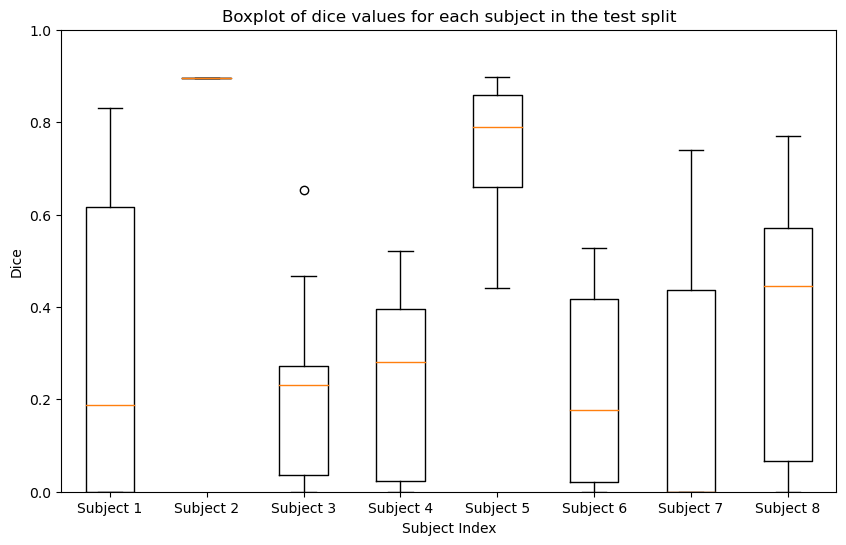

In [210]:
# Example data: a list of lists
data = Dice_for_subjects

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Create the boxplot
plt.boxplot(data)

# Adding titles and labels
plt.title('Boxplot of dice values for each subject in the test split')
plt.xlabel('Subject Index')
plt.ylabel('Dice')

# Customize x-axis labels if needed
plt.xticks(range(1, len(data) + 1), ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8'])

# Set y-axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()